<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/04-small_cap_value.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Small Cap Value and Momentum

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

### Small Cap Value and Growth

- small cap $\approx$ Russell 2000
- value usually measured by PB or PE
- some academic work (Fama-French) found PB is a better predictor of returns
- low PB = value, high PB = growth
- academics usually use BP instead of PB and call it book-to-market
- high BP = value, low BP = growth
- small-cap growth has historically had very poor returns

### Value and Momentum Portfolios I

- get marketcap data in addition to prices
- calculate momentum
- keep stocks between 1,001 and 3,000 in market cap
- create 5x5 sort on value and momentum
- compute equally weighted portfolio returns

### Value and Momentum Portfolios II

- rank each stock between 1,001 and 3,000 on value 
    - low rank = best (low pb)
- rank each stock also on momentum
    - low rank = best (high momentum)
- add ranks to get a single combined rank
    - low combined rank = best
- go long best 50 and short worst 50


### Value and Momentum Portfolios III

- For long only portfolio, choose best stocks in each sector and match sector weights to benchmark (e.g., Russell 2000).
- For long-short portfolio, match shorts and longs in each sector to get market-neutral and sector-neutral portfolio.

### Value and Momentum Portfolios IV

- Use machine learning to find the optimal way to combine value and momentum
- And add other predictors (ROE, investment rate, short-term reversal, ...)

### Data and Procedure

- Get sectors from tickers table
- Get marketcap and pb from weekly table
- Get closeadj and closeunadj from sep_weekly as before
- Calculate momentum as before
- Filter to 1,001-3,000 on marketcap each week
- Form portfolios

### Create connection

In [193]:
from sqlalchemy import create_engine
import pymssql
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
conn = create_engine(string).connect()

### Get data

In [194]:
import pandas as pd 
tickers = pd.read_sql(
    """ 
    select ticker, sector from tickers
    """,
    conn
)
tickers.head(3)

,ticker,sector
0,A,Healthcare
1,AA,Basic Materials
2,AAAB,Financial Services


In [195]:
weekly = pd.read_sql(
    """ 
    select ticker, date, marketcap, pb, lastupdated
    from weekly
    where date>='2010-01-01' and marketcap>0 and pb>0
    order by ticker, date, lastupdated
    """,
    conn
)
weekly = weekly.groupby(["ticker", "date", "lastupdated"]).last()
weekly = weekly.droplevel("lastupdated")
weekly.head(3)

marketcap   pb
ticker date                      
A      2010-01-08    10918.4  4.4
       2010-01-15    10751.0  4.3
       2010-01-22    10744.0  4.3

In [196]:
sep_weekly = pd.read_sql(
    """ 
    select ticker, date, closeadj, closeunadj, lastupdated 
    from sep_weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date", "lastupdated"]).last()
sep_weekly = sep_weekly.droplevel("lastupdated")

### Calculate momentum

In [197]:
sep_weekly["ret"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
sep_weekly["annual"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
sep_weekly["monthly"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
sep_weekly["mom"] = sep_weekly.groupby("ticker", group_keys=False).apply(
    lambda d: (1+d.annual)/(1+d.monthly) - 1
)
sep_weekly = sep_weekly[["ret", "mom", "closeunadj"]].dropna().reset_index()

### Merge marketcap and pb

In [198]:
df = sep_weekly.merge(weekly, on=["ticker", "date"], how="inner")
df = df.merge(tickers, on="ticker", how="left")
df.head(3)

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector
0,A,2011-01-07,-0.000988,0.199287,41.88,14557.7,4.5,Healthcare
1,A,2011-01-14,0.008130,0.270914,42.22,14675.8,4.5,Healthcare
2,A,2011-01-21,0.050456,0.337839,44.35,15416.2,4.8,Healthcare


### Save this week's data

In [199]:
today = df[df.date==df.date.max()]
today.head(3)

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector
668,A,2023-10-27,-0.059141,-0.188863,102.77,30069.2,5.4,Healthcare
981,AA,2023-10-27,-0.020825,-0.256682,23.51,4195.9,0.9,Basic Materials
1644,AADI,2023-10-27,0.039120,-0.626255,4.25,104.2,0.8,Healthcare


### Shift predictors and filtering variables to backtest

In [200]:
df = df.set_index(["ticker", "date"])
df[["mom", "pb", "marketcap", "closeunadj"]] = df.groupby("ticker", group_keys=False)[["mom", "pb", "marketcap", "closeunadj"]].shift()
df = df.dropna()
df.head(3)

ret       mom  closeunadj  marketcap   pb      sector
ticker date                                                                  
A      2011-01-14  0.008130  0.199287       41.88    14557.7  4.5  Healthcare
       2011-01-21  0.050456  0.270914       42.22    14675.8  4.5  Healthcare
       2011-01-28 -0.075973  0.337839       44.35    15416.2  4.8  Healthcare

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2640984 entries, ('A', datetime.date(2011, 1, 14)) to ('ZYXI', datetime.date(2023, 10, 27))
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ret         float64
 1   mom         float64
 2   closeunadj  float64
 3   marketcap   float64
 4   pb          float64
 5   sector      object 
dtypes: float64(5), object(1)
memory usage: 131.3+ MB


### Filter out penny stocks and filter to small caps

In [202]:
df = df[df.closeunadj>5]
df["rnk"] = df.groupby("date").marketcap.rank(ascending=False, method="first")
df = df[(df.rnk>1000) & (df.rnk<=3000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1324775 entries, ('AA', datetime.date(2019, 9, 6)) to ('ZYXI', datetime.date(2023, 10, 27))
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ret         1324775 non-null  float64
 1   mom         1324775 non-null  float64
 2   closeunadj  1324775 non-null  float64
 3   marketcap   1324775 non-null  float64
 4   pb          1324775 non-null  float64
 5   sector      1324775 non-null  object 
 6   rnk         1324775 non-null  float64
dtypes: float64(6), object(1)
memory usage: 76.1+ MB


In [203]:
df.reset_index().groupby("date").ticker.count()

date
2011-01-14    2000
2011-01-21    2000
2011-01-28    2000
2011-02-04    2000
2011-02-11    2000
              ... 
2023-09-29    1865
2023-10-06    1853
2023-10-13    1837
2023-10-20    1829
2023-10-27    1802
Name: ticker, Length: 668, dtype: int64

In [204]:
df.head(3)

ret       mom  closeunadj  marketcap   pb   
ticker date                                                         
AA     2019-09-06  0.025653 -0.477529       17.17     3186.0  0.7  \
       2020-01-31 -0.153060 -0.231754       17.12     3177.0  0.7   
       2020-02-07 -0.017890 -0.237294       14.50     2759.5  0.6   

                            sector     rnk  
ticker date                                 
AA     2019-09-06  Basic Materials  1006.0  
       2020-01-31  Basic Materials  1076.0  
       2020-02-07  Basic Materials  1162.0

### Value and Momentum Portfolios I

In [205]:
df["value_group"] = df.groupby("date", group_keys=False).pb.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)
df["mom_group"] = df.groupby("date", group_keys=False).mom.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)
rets = df.groupby(["date", "value_group", "mom_group"]).ret.mean()
rets = rets.unstack().unstack()
rets.head(3)

mom_group           1                                                 2   
value_group         1         2         3         4         5         1   
date                                                                      
2011-01-14  -0.004985 -0.014070 -0.008452 -0.006321 -0.009538 -0.006124  \
2011-01-21   0.018622  0.018095  0.020878  0.013126  0.003709  0.013191   
2011-01-28  -0.026927 -0.021369 -0.030210 -0.027047 -0.030028 -0.010046   

mom_group                                            ...         4             
value_group         2         3         4         5  ...         1         2   
date                                                 ...                       
2011-01-14  -0.011125 -0.008001 -0.010104 -0.015608  ... -0.000915 -0.011512  \
2011-01-21   0.016730  0.016485  0.010804  0.009455  ...  0.010303  0.011461   
2011-01-28  -0.016295 -0.016319 -0.029533 -0.041064  ... -0.015679 -0.019126   

mom_group                                         5                       
value_group         3         4         5         1         2         3   
date                                                                      
2011-01-14  -0.004276 -0.002012  0.002801 -0.002485 -0.012314 -0.001888  \
2011-01-21   0.018304  0.011691  0.020583  0.002941  0.019631  0.018831   
2011-01-28  -0.017971 -0.019023 -0.024112 -0.015446 -0.025357 -0.016465   

mom_group                        
value_group         4         5  
date                             
2011-01-14   0.001080  0.012422  
2011-01-21   0.022498  0.009367  
2011-01-28  -0.040102 -0.044374  

[3 rows x 25 columns]

In [206]:
(52*rets.mean()).unstack().round(3)

value_group,1,2,3,4,5
mom_group,,,,,
1,0.040,0.038,0.060,0.052,-0.003
2,0.114,0.087,0.076,0.079,0.066
3,0.129,0.092,0.094,0.102,0.097
4,0.143,0.095,0.094,0.117,0.079
5,0.178,0.125,0.112,0.104,0.138


### How many stocks are in the groups?

In [207]:
counts = df.groupby(["date", "value_group", "mom_group"]).ret.count()
counts = counts.unstack().unstack()
counts.tail(3)

mom_group      1                    2                  ...   4               
value_group    1   2   3   4   5    1   2   3   4   5  ...   1   2   3   4   
date                                                   ...                   
2023-10-13   131  74  61  57  45  103  94  57  53  60  ...  50  75  87  79  \
2023-10-20   138  75  57  50  46  108  94  59  47  58  ...  58  71  80  66   
2023-10-27   144  63  54  52  48  107  94  52  57  50  ...  62  80  55  79   

mom_group         5                   
value_group   5   1   2   3   4    5  
date                                  
2023-10-13   76  32  38  76  94  128  
2023-10-20   91  28  41  85  95  117  
2023-10-27   84  36  36  74  98  117  

[3 rows x 25 columns]

### Value and Momentum Portfolios II

- Rank stocks on momentum each week: 1=best, 2=next best, etc. (best=high momentum)
- Rank stocks on pb each week: 1=best, 2=next best, etc. (best=low pb)
- Add momentum and pb ranks: lowest combined ranks are best stocks
- Test A: sort into deciles on combined ranks and compute equally weighted returns
- Test B: go long best 50 stocks and short worst 50 stocks and compute returns

In [208]:
df["mom_rnk"] = df.groupby("date", group_keys=False).mom.rank(ascending=False, method="first")
df["pb_rnk"] = df.groupby("date", group_keys=False).pb.rank(ascending=True, method="first")
df["combined_rnk"] = df.mom_rnk + df.pb_rnk

### Test A: Deciles

In [209]:
df["decile"] = df.groupby("date", group_keys=False).combined_rnk.apply(
    lambda x: pd.qcut(x, 10, labels=range(1, 11))
)
rets = df.groupby(["date", "decile"]).ret.mean()
rets = rets.unstack()
52*rets.mean()

decile
1     0.140782
2     0.111245
3     0.110181
4     0.106055
5     0.096709
6     0.103076
7     0.092262
8     0.056943
9     0.074983
10    0.034706
dtype: float64

### Test B: Top 50 and Bottom 50

In [210]:
df["rnk_long"] = df.groupby("date", group_keys=False).combined_rnk.rank(method="first")
df["rnk_short"] = df.groupby("date", group_keys=False).combined_rnk.rank(ascending=False, method="first")
longs = df[df.rnk_long<=50]
shorts = df[df.rnk_short<=50]
long_rets = longs.groupby("date").ret.mean()
short_rets = shorts.groupby("date").ret.mean()
print(f"annualized mean long return is {52*long_rets.mean():.2%}")
print(f"annualized mean short return is {52*short_rets.mean():.2%}")

annualized mean long return is 17.82%
annualized mean short return is 0.23%


<Axes: xlabel='date'>

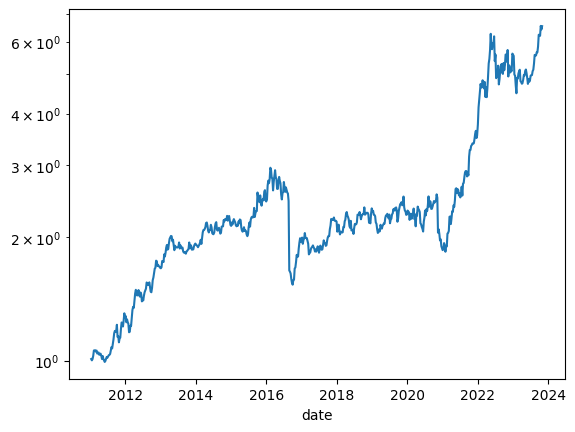

In [211]:
(1+long_rets-short_rets).cumprod().plot(logy=True)

### What are the top 50 and bottom 50 today?

In [212]:
today = today[today.closeunadj>5]
today["rnk"] = today.groupby("date").marketcap.rank(ascending=False, method="first")
today = today[(today.rnk>1000) & (today.rnk<=3000)]
today["mom_rnk"] = today.mom.rank(ascending=False, method="first")
today["pb_rnk"] = today.pb.rank(ascending=True, method="first")
today["combined_rnk"] = (today.mom_rnk + today.pb_rnk).astype(int)
today["rnk_long"] = today.combined_rnk.rank(method="first")
today["rnk_short"] = today.combined_rnk.rank(ascending=False, method="first")
top50 = today[today.rnk_long<=50]
bottom50 = today[today.rnk_short<=50]

In [213]:
top50.sort_values(by="combined_rnk")

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector,rnk,mom_rnk,pb_rnk,combined_rnk,rnk_long,rnk_short
772871,EHTH,2023-10-27,-0.040293,1.587413,7.860,220.8,0.4,Financial Services,2419.0,26.0,32.0,58,1.0,1779.0
427948,CBUS,2023-10-27,-0.453433,1.501030,10.270,218.6,0.5,Healthcare,2424.0,30.0,69.0,99,2.0,1778.0
2367118,TRML,2023-10-27,0.284404,0.906040,14.000,59.9,0.4,Healthcare,2698.0,78.0,53.0,131,3.0,1777.0
1429651,LSEA,2023-10-27,-0.001379,0.798000,7.240,279.4,0.4,Real Estate,2325.0,97.0,39.0,136,4.0,1776.0
2197648,SPHR,2023-10-27,-0.009177,0.784908,33.470,1160.7,0.4,Communication Services,1652.0,100.0,51.0,151,5.0,1775.0
387833,BZH,2023-10-27,0.045982,1.177448,23.430,734.3,0.7,Consumer Cyclical,1899.0,48.0,221.0,269,6.0,1774.0
2449388,USAP,2023-10-27,0.158678,0.771622,14.020,127.4,0.6,Basic Materials,2577.0,102.0,197.0,299,7.0,1773.0
1761051,OPRT,2023-10-27,-0.066102,0.377863,5.510,187.6,0.4,Financial Services,2483.0,272.0,44.0,316,8.0,1772.0
1597522,MUX,2023-10-27,-0.083979,0.785714,7.090,336.6,0.7,Basic Materials,2266.0,99.0,267.0,366,9.0,1771.0
1488461,MDV,2023-10-27,0.017391,0.669000,15.210,114.8,0.7,Real Estate,2601.0,125.0,260.0,385,10.0,1770.0


In [214]:
bottom50.sort_values(by="combined_rnk")

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector,rnk,mom_rnk,pb_rnk,combined_rnk,rnk_long,rnk_short
2425203,UG,2023-10-27,-0.054757,-0.436757,6.180,28.4,2.7,Consumer Defensive,2751.0,1664.0,1382.0,3046,1730.0,50.0
1121494,HLIT,2023-10-27,-0.045367,-0.384665,9.890,1106.8,3.2,Technology,1678.0,1596.0,1456.0,3052,1731.0,49.0
1570573,MRVI,2023-10-27,-0.099855,-0.401914,6.220,1561.3,3.0,Healthcare,1490.0,1623.0,1431.0,3054,1732.0,48.0
124978,AMLX,2023-10-27,-0.065321,-0.496425,15.740,1060.5,2.7,Healthcare,1703.0,1701.0,1354.0,3055,1733.0,47.0
1869626,PLMR,2023-10-27,0.000203,-0.404552,49.360,1221.3,3.0,Financial Services,1613.0,1625.0,1433.0,3058,1734.0,46.0
229881,AUID,2023-10-27,-0.200000,-0.308036,6.000,47.2,4.9,Technology,2723.0,1460.0,1599.0,3059,1735.0,45.0
291701,BE,2023-10-27,-0.135279,-0.284017,9.780,2048.1,6.7,Industrials,1341.0,1409.0,1654.0,3063,1736.0,44.0
1903132,PRCT,2023-10-27,-0.056761,-0.276356,26.090,1181.3,7.6,Healthcare,1640.0,1393.0,1678.0,3071,1738.0,43.0
260770,AYX,2023-10-27,-0.099599,-0.233787,31.460,2235.3,43.0,Technology,1293.0,1304.0,1767.0,3071,1737.0,42.0
244448,AVXL,2023-10-27,0.000000,-0.465742,5.200,426.1,2.9,Healthcare,2169.0,1685.0,1399.0,3084,1739.0,41.0


### Sector weights

In [215]:
top50.groupby("sector").rnk.count()

sector
Basic Materials            3
Communication Services     2
Consumer Cyclical         11
Energy                     1
Financial Services        19
Healthcare                 4
Industrials                5
Real Estate                5
Name: rnk, dtype: int64

In [216]:
bottom50.groupby("sector").rnk.count()

sector
Basic Materials            1
Communication Services     1
Consumer Cyclical          3
Consumer Defensive         2
Energy                     2
Financial Services         3
Healthcare                19
Industrials                3
Technology                15
Utilities                  1
Name: rnk, dtype: int64

### Value and Momentum Portfolios III

- Rank on combined rank separately in each sector
- Do that by grouping by date and sector instead of just date
- Choose top 5 and bottom 5 in each sector to get sector neutrality

In [217]:
df["rnk_long"] = df.groupby(["date", "sector"], group_keys=False).combined_rnk.rank(method="first")
df["rnk_short"] = df.groupby(["date", "sector"], group_keys=False).combined_rnk.rank(ascending=False, method="first")
longs = df[df.rnk_long<=5]
shorts = df[df.rnk_short<=5]
long_rets = longs.groupby("date").ret.mean()
short_rets = shorts.groupby("date").ret.mean()
print(f"annualized mean long return is {52*long_rets.mean():.2%}")
print(f"annualized mean short return is {52*short_rets.mean():.2%}")

annualized mean long return is 15.07%
annualized mean short return is 1.82%


<Axes: xlabel='date'>

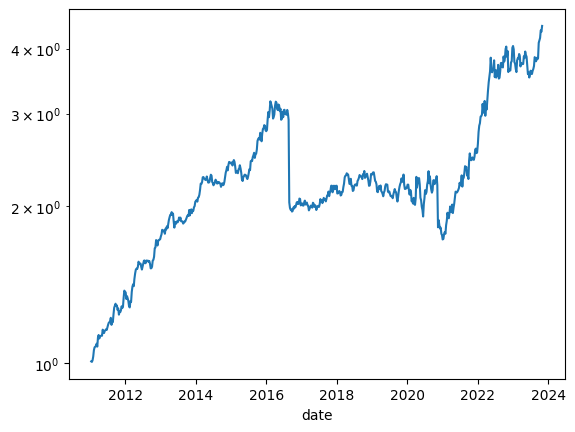

In [218]:
(1+long_rets-short_rets).cumprod().plot(logy=True)

### Best and worst stocks today in sector-neutral strategy

- Just group by sector when ranking
- Choose top 5 and bottom 5 in each sector

In [226]:
today["rnk_long"] = today.groupby("sector").combined_rnk.rank(method="first")
today["rnk_short"] = today.groupby("sector").combined_rnk.rank(ascending=False, method="first")
top = today[today.rnk_long<=5].copy()
bottom = today[today.rnk_short<=5].copy()

In [227]:
top.sort_values(by="combined_rnk")

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector,rnk,mom_rnk,pb_rnk,combined_rnk,rnk_long,rnk_short
772871,EHTH,2023-10-27,-0.040293,1.587413,7.860,220.8,0.4,Financial Services,2419.0,26.0,32.0,58,1.0,433.0
427948,CBUS,2023-10-27,-0.453433,1.501030,10.270,218.6,0.5,Healthcare,2424.0,30.0,69.0,99,1.0,289.0
2367118,TRML,2023-10-27,0.284404,0.906040,14.000,59.9,0.4,Healthcare,2698.0,78.0,53.0,131,2.0,288.0
1429651,LSEA,2023-10-27,-0.001379,0.798000,7.240,279.4,0.4,Real Estate,2325.0,97.0,39.0,136,1.0,131.0
2197648,SPHR,2023-10-27,-0.009177,0.784908,33.470,1160.7,0.4,Communication Services,1652.0,100.0,51.0,151,1.0,45.0
387833,BZH,2023-10-27,0.045982,1.177448,23.430,734.3,0.7,Consumer Cyclical,1899.0,48.0,221.0,269,1.0,191.0
2449388,USAP,2023-10-27,0.158678,0.771622,14.020,127.4,0.6,Basic Materials,2577.0,102.0,197.0,299,1.0,86.0
1761051,OPRT,2023-10-27,-0.066102,0.377863,5.510,187.6,0.4,Financial Services,2483.0,272.0,44.0,316,2.0,432.0
1597522,MUX,2023-10-27,-0.083979,0.785714,7.090,336.6,0.7,Basic Materials,2266.0,99.0,267.0,366,2.0,85.0
1488461,MDV,2023-10-27,0.017391,0.669000,15.210,114.8,0.7,Real Estate,2601.0,125.0,260.0,385,2.0,130.0


In [228]:
bottom.sort_values(by="combined_rnk")

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector,rnk,mom_rnk,pb_rnk,combined_rnk,rnk_long,rnk_short
1756063,OPAD,2023-10-27,-0.078363,-0.253366,7.880,214.5,1.6,Real Estate,2433.0,1353.0,992.0,2345,127.0,5.0
2428020,UHT,2023-10-27,0.013589,-0.116303,38.040,525.8,2.4,Real Estate,2063.0,1050.0,1297.0,2347,128.0,4.0
248602,AWR,2023-10-27,0.002974,-0.106610,77.560,2867.9,3.8,Utilities,1143.0,1025.0,1518.0,2543,26.0,5.0
113290,ALX,2023-10-27,0.015523,-0.137932,179.250,915.5,3.4,Real Estate,1782.0,1102.0,1477.0,2579,129.0,3.0
1433593,LTHM,2023-10-27,-0.045483,-0.411257,15.110,2715.5,1.6,Basic Materials,1171.0,1633.0,986.0,2619,82.0,5.0
1575731,MSEX,2023-10-27,0.023203,-0.215540,63.500,1127.0,2.7,Utilities,1673.0,1264.0,1371.0,2635,27.0,4.0
1043620,GOOD,2023-10-27,-0.030808,-0.242557,11.640,464.6,2.5,Real Estate,2124.0,1328.0,1311.0,2639,130.0,2.0
1195703,IDT,2023-10-27,-0.038408,-0.164139,27.790,699.2,3.6,Communication Services,1929.0,1159.0,1501.0,2660,41.0,5.0
474829,CHEF,2023-10-27,-0.063641,-0.419726,17.950,712.0,1.7,Consumer Defensive,1913.0,1649.0,1018.0,2667,64.0,5.0
2359074,TR,2023-10-27,0.013039,-0.228893,30.300,2119.3,2.7,Consumer Defensive,1322.0,1293.0,1381.0,2674,65.0,4.0


In [229]:
top.groupby("sector").rnk.count()

sector
Basic Materials           5
Communication Services    5
Consumer Cyclical         5
Consumer Defensive        5
Energy                    5
Financial Services        5
Healthcare                5
Industrials               5
Real Estate               5
Technology                5
Utilities                 5
Name: rnk, dtype: int64

In [230]:
bottom.groupby("sector").rnk.count()

sector
Basic Materials           5
Communication Services    5
Consumer Cyclical         5
Consumer Defensive        5
Energy                    5
Financial Services        5
Healthcare                5
Industrials               5
Real Estate               5
Technology                5
Utilities                 5
Name: rnk, dtype: int64

### How many shares to buy/sell?

- Can do this either for top50 and bottom50 or top and bottom (sector-neutral)
- $1,000,000 to invest long and short
- Divide by number of stocks to get $ per stock
- Divide by price to get shares per stock

### Long side

In [231]:
top["shares"] = (1000000 / 55) / top.closeunadj
top["shares"] = top.shares.round(0).astype(int)
top[["sector", "combined_rnk", "ticker", "shares"]].sort_values(by=["sector", "combined_rnk"])

,sector,combined_rnk,ticker,shares
2449388,Basic Materials,299,USAP,1297
1597522,Basic Materials,366,MUX,2564
950535,Basic Materials,423,FRD,1872
2638060,Basic Materials,683,ZEUS,368
986128,Basic Materials,761,GATO,3629
2197648,Communication Services,151,SPHR,543
2300744,Communication Services,528,TDS,1021
2455127,Communication Services,704,USM,439
1177442,Communication Services,863,IAC,435
2116089,Communication Services,946,SGA,949


### Short side

In [232]:
bottom["shares"] = (1000000 / 55) / bottom.closeunadj
bottom["shares"] = bottom.shares.round(0).astype(int)
bottom[["sector", "combined_rnk", "ticker", "shares"]].sort_values(by=["sector", "combined_rnk"])

,sector,combined_rnk,ticker,shares
1433593,Basic Materials,2619,LTHM,1203
1573351,Basic Materials,2675,MSB,901
2165284,Basic Materials,2689,SMID,939
1555752,Basic Materials,2779,MP,1102
2379344,Basic Materials,3443,TSE,3035
1195703,Communication Services,2660,IDT,654
1755960,Communication Services,2738,OOMA,1693
934187,Communication Services,2768,FNGR,3218
1042555,Communication Services,2889,GOGO,1707
2388282,Communication Services,3229,TTGT,720


In [237]:
with pd.ExcelWriter("portfolios 2023-11-01.xlsx") as writer:
    top.drop(columns="date").to_excel(writer, "top", index=False)
    bottom.drop(columns="date").to_excel(writer, "bottom", index=False)
    top50.drop(columns="date").to_excel(writer, "top50", index=False)
    bottom50.drop(columns="date").to_excel(writer, "bottom50", index=False)
    today.drop(columns="date").to_excel(writer, "today", index=False)